In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
import numpy as np
import os
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import matplotlib.pyplot as plt

import PIL.Image
from IPython.display import display

Using TensorFlow backend.


In [2]:
def load_image(filename):
    image = PIL.Image.open(filename) # open colour image
    image = np.array(image)
    
    return np.int32(image)

In [3]:
files = (os.listdir("../input/data"))

images = []
labels = []


In [4]:
for file in sorted(files):
    im = load_image("../input/data/" +file)
    images.append(im)
    labels.append(np.array(list((file[4:9]))))
images_array = np.asarray(images, dtype='int32')
labels_array = np.asarray(labels, dtype='int32')

labels_array.shape

(700, 5)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.20)

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (560, 250, 250, 3)
560 train samples
140 test samples
y_train shape: (560, 5)


In [7]:
class_freq = sum(labels_array)
class_weights_dict = {0: 1.0 / class_freq[0], 1: 1.0 / class_freq[1],
                      2: 1.0 / class_freq[2],3: 1.0 / class_freq[3],4: 1.0 / class_freq[4]}
class_freq

array([465, 568, 275, 142, 121], dtype=int32)

In [8]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



In [9]:
def resnet_v1(input_shape, depth, num_classes=5):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='sigmoid',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = resnet_v1(input_shape=(250, 250, 3), depth=8)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 250, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 250, 250, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 250, 250, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
batch_size = 8
epochs = 20
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
          verbose=1,
         class_weight=class_weights_dict)

Instructions for updating:
Use tf.cast instead.
Train on 560 samples, validate on 140 samples
Epoch 1/20
560/560 [==============================] - 8s 14ms/step - loss: 0.0722 - acc: 0.3518 - val_loss: 3.5194 - val_acc: 0.3571
Epoch 2/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0673 - acc: 0.3143 - val_loss: 3.4171 - val_acc: 0.3500
Epoch 3/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0629 - acc: 0.3071 - val_loss: 3.3808 - val_acc: 0.3643
Epoch 4/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0588 - acc: 0.4000 - val_loss: 3.3458 - val_acc: 0.5571
Epoch 5/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0552 - acc: 0.5107 - val_loss: 3.2844 - val_acc: 0.5071
Epoch 6/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0518 - acc: 0.5250 - val_loss: 3.2496 - val_acc: 0.5214
Epoch 7/20
560/560 [==============================] - 3s 5ms/step - loss: 0.0487 - acc: 0.5143 - val_loss: 3.2156

In [31]:
sum_of_squared_error_train=(sum(sum(np.square((model.predict(x_train)>0.2).astype('int32')- y_train))))
sum_of_squared_error_test=(sum(sum(np.square((model.predict(x_test)>0.2).astype('int32')- y_test))))
print("Sum of squared error accuracy train : " + str((1 - sum_of_squared_error_train / (len(y_train)*5))*100))
print("Sum of squared error accuracy test : " + str((1 - sum_of_squared_error_test / (len(y_test)*5))*100))

Sum of squared error accuracy train : 87.60714285714286
Sum of squared error accuracy test : 78.71428571428571


Ground Truth : [0 1 0 0 1]
Predictions : [0 1 0 0 1]


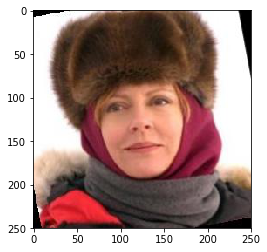

In [35]:
#Check for a random image its ground truth compared to predicted data
n = 567
print("Ground Truth : " + str((model.predict(images_array[n:n+1])>0.2)[0].astype('int32')))
print("Predictions : "+ str(labels_array[n]))
plt.imshow(images_array[n])

Enter Input Query : 
Gender: 1 for Male 0 for Female -1 for Not Sure : 
0
Skin Color: 1 for Light Skinned 0 for Dark Skinned -1 for Not Sure : 
0
Hair Color: 1 for Light 0 for Dark -1 for Not Sure : 
-1
Eye Gear: 1 for Yes 0 for No -1 for Not Sure : 
-1
Head Gear: 1 for Yes 0 for No -1 for Not Sure : 
-1
Following are the ID's of potential suspects and their images are displayed for verification 
[14, 17, 39, 56, 95]
Enter number ID of person to display image
14


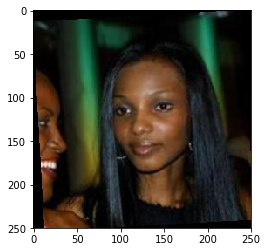

In [116]:
# Query on test
array_of_knowns = []
query = []
corpus = []
prediction_array = ((model.predict(images_array)>0.2)[0].astype('int32'))
print("Enter Input Query : ")
print("Gender: 1 for Male 0 for Female -1 for Not Sure : ")
gender = input() 
print("Skin Color: 1 for Light Skinned 0 for Dark Skinned -1 for Not Sure : ")
sc = input()
print("Hair Color: 1 for Light 0 for Dark -1 for Not Sure : ")
hc = input()
print("Eye Gear: 1 for Yes 0 for No -1 for Not Sure : ")
eg = input()
print("Head Gear: 1 for Yes 0 for No -1 for Not Sure : ")
hg = input()

array_for_search = enumerate((np.array([gender, sc, hc, eg, hg])).astype('int32'))
array_for_search_1 = (np.array([gender, sc, hc, eg, hg])).astype('int32')
all_arrays_to_search = []

suspect_ID = []
for i in array_for_search:
    if i[1]!=-1:
        array_of_knowns.append(i[0])

for i in array_of_knowns:
    query.append(array_for_search_1[i])
    
for i in (y_test):
    this_corpus=[]
    for j in array_of_knowns:
        this_corpus.append(i[j])
    corpus.append(this_corpus)

for j in enumerate(corpus):
    if np.array_equal(query, j[1]):
        suspect_ID.append(j[0])

print("Following are the ID's of potential suspects and their images are displayed for verification ")
print(suspect_ID)

print("Enter number ID of person to display image")
n = input()
plt.imshow(x_test[int(n)])